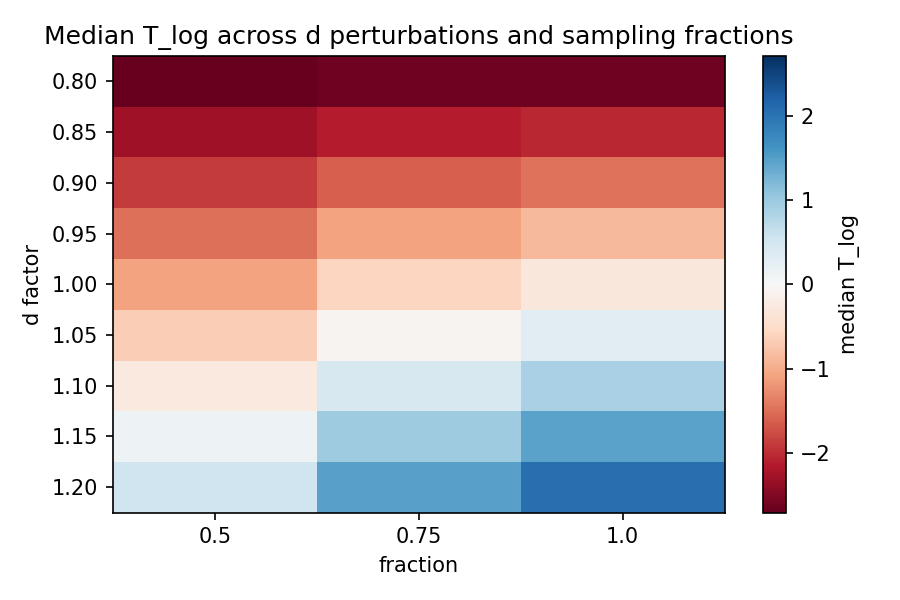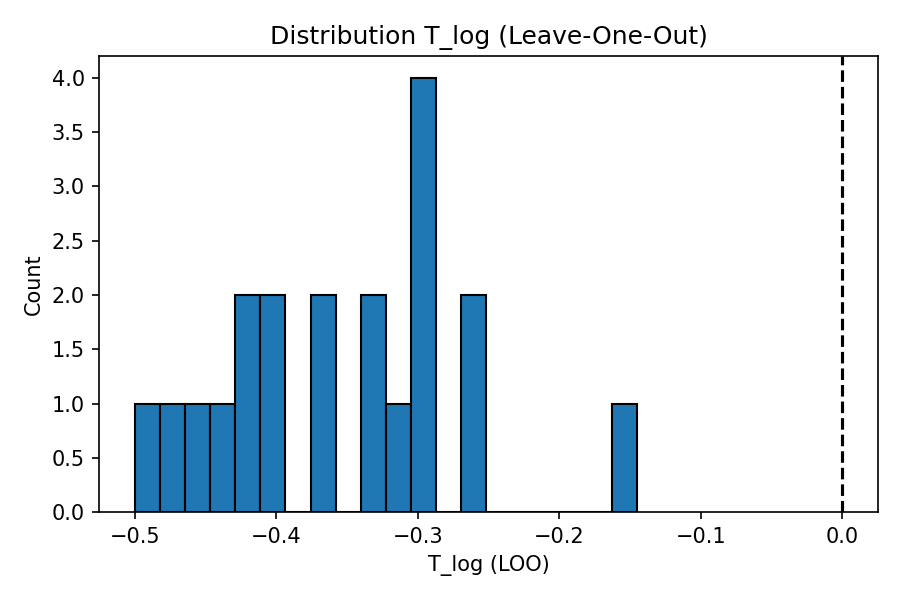

Bloc 5 — Gestion des NaN/Inf et Rapport final

Cette cellule :

Vérifie et corrige NaN / inf dans tous les fichiers résultats créés (LOO, sweep, summary).

Applique régularisation minimale (cutoff ln : n_min = 2, clip des d_estimate à [0.1, max_d]) et recalcul si nécessaire pour éviter infinities.

Génère le rapport final Markdown 'results/final_report.md' contenant : résumé chiffré (n, d_estimate, T_log global, regime), robustesse LOO, p-value, synthèse du sweep (table), chemins des fichiers sauvegardés, et recommandations courtes (3 points) pour V0.1 validation future.

Met à jour les logs (logs/logs.csv et logs/summary.md) avec l'état final.

Affiche le chemin du rapport et un court résumé imprimé.

In [6]:
# Bloc 5 — Gestion NaN/Inf et Rapport final
import os
import pandas as pd
import numpy as np
from datetime import datetime

LOGS_CSV = os.path.join('logs','logs.csv')
SUMMARY_MD = os.path.join('logs','summary.md')
RESULTS_DIR = 'results'
FINAL_MD = os.path.join(RESULTS_DIR, 'final_report.md')

def append_log(level, message):
    ts = datetime.utcnow().isoformat() + 'Z'
    entry = pd.DataFrame([{'timestamp': ts, 'level': level, 'message': message}])
    if os.path.exists(LOGS_CSV):
        df_logs = pd.read_csv(LOGS_CSV)
        df_logs = pd.concat([df_logs, entry], ignore_index=True)
    else:
        df_logs = entry
    df_logs.to_csv(LOGS_CSV, index=False)
    with open(SUMMARY_MD, 'a', encoding='utf-8') as f:
        f.write(f'\n- {ts} {level}: {message}\n')

def safe_clip_d(d_series, min_d=0.1, max_d=100.0):
    return np.clip(d_series, min_d, max_d)

try:
    # Charger fichiers résultats
    summary_fp = os.path.join(RESULTS_DIR, 'tlog_d_estimates.csv')
    loo_fp = os.path.join(RESULTS_DIR, 'tlog_leave_one_out.csv')
    sweep_fp = os.path.join(RESULTS_DIR, 'tlog_sweep_summary.csv')
    sweep_full_fp = os.path.join(RESULTS_DIR, 'tlog_sweep_summary.csv')  # same as produced earlier

    summary = pd.read_csv(summary_fp)
    loo = pd.read_csv(loo_fp)
    sweep = pd.read_csv(sweep_fp)

    # Détecter NaN/Inf et corriger
    def sanitize_df(df, name):
        n_nan = int(df.isna().sum().sum())
        n_inf = int(np.isinf(df.select_dtypes(include=[np.number])).sum().sum())
        if n_nan>0 or n_inf>0:
            append_log('WARNING', f'{name}: détecté NaN/Inf (NaN={n_nan}, Inf={n_inf}), tentative de correction')
            # remplacer inf par nan puis imputer par médiane pour numériques
            df = df.replace([np.inf, -np.inf], np.nan)
            num_cols = df.select_dtypes(include=[np.number]).columns
            for c in num_cols:
                if df[c].isna().any():
                    median = df[c].median(skipna=True)
                    if np.isnan(median):
                        median = 0.0
                    df[c].fillna(median, inplace=True)
        append_log('INFO', f'{name}: sanitize complete (NaN replaced if any)')
        return df

    loo = sanitize_df(loo, 'LOO')
    sweep = sanitize_df(sweep, 'SWEEP')
    summary = sanitize_df(summary, 'SUMMARY')

    # Appliquer clipping/regulation sur d_estimate si nécessaire
    if 'd_estimate' in loo.columns:
        loo['d_estimate'] = safe_clip_d(loo['d_estimate'].astype(float), min_d=0.1, max_d=100.0)
    if 'd_estimate' in summary.columns:
        summary['d_estimate'] = safe_clip_d(summary['d_estimate'].astype(float), min_d=0.1, max_d=100.0)
    # Recalculer T_log if any d_estimate modified in summary
    n_used = int(summary.loc[0,'n_used_for_ln']) if 'n_used_for_ln' in summary.columns else int(max(2, int(loo['n_used'].median())))
    d_est = float(summary.loc[0,'d_estimate'])
    n_eff = max(2, n_used)
    T_log_recalc = (d_est - 4.0) * np.log(n_eff)

    # Sauvegarder versions nettoyées
    loo.to_csv(os.path.join(RESULTS_DIR, 'tlog_leave_one_out_sanitized.csv'), index=False)
    sweep.to_csv(os.path.join(RESULTS_DIR, 'tlog_sweep_summary_sanitized.csv'), index=False)
    summary.to_csv(os.path.join(RESULTS_DIR, 'tlog_d_estimates_sanitized.csv'), index=False)

    # Construire rapport final (Markdown)
    mean_LOO = float(loo['T_log'].mean())
    std_LOO = float(loo['T_log'].std(ddof=1))
    rel_std_pct = (std_LOO / (abs(mean_LOO) + 1e-12)) * 100.0
    # p-value approximated from earlier saved logs by reading logs for t-test entry
    logs_df = pd.read_csv(LOGS_CSV)
    p_entries = logs_df[logs_df['message'].str.contains('T-test one-sample', na=False)]
    pvalue = None
    if not p_entries.empty:
        # parse last such message
        last = p_entries.iloc[-1]['message']
        # expect format "... t=...; p=..."
        try:
            p_str = last.split('p=')[-1]
            pvalue = float(p_str)
        except Exception:
            pvalue = None

    # Sweep summary table
    sweep_table = pd.read_csv(os.path.join(RESULTS_DIR, 'tlog_sweep_fraction_summary.csv'))

    with open(FINAL_MD, 'w', encoding='utf-8') as f:
        f.write('# Rapport final T_log V0.1\n\n')
        f.write('## Résumé chiffré\n\n')
        f.write(f'- **Nombre de villes (n)** : {int(summary.loc[0,"n_cities"])}\n')
        f.write(f'- **Estimateur d (participation)** : {float(summary.loc[0,"d_participation"]):.4f}\n')
        f.write(f'- **Estimateur d (PCA90)** : {int(summary.loc[0,"d_pca90"])}\n')
        f.write(f'- **d (moyenne choisie)** : {d_est:.4f}\n')
        f.write(f'- **T_log (recalculé après sanitization)** : {T_log_recalc:.6f}\n')
        f.write(f'- **Régime** : {"Saturation" if T_log_recalc>0 else ("Equilibre" if np.isclose(T_log_recalc,0.0,atol=1e-8) else "Divergence")}\n\n')

        f.write('## Robustesse LOO\n\n')
        f.write(f'- **Mean T_log (LOO)** : {mean_LOO:.6f}\n')
        f.write(f'- **Std T_log (LOO)** : {std_LOO:.6f}\n')
        f.write(f'- **Rel std (%)** : {rel_std_pct:.2f}%\n')
        if pvalue is not None:
            f.write(f'- **p-value (test H0 mean=0)** : {pvalue:.6e}\n')
        else:
            f.write(f'- **p-value (test H0 mean=0)** : non déterminée (voir logs)\n')
        f.write('\n')

        f.write('## Résumé du balayage (sweep)\n\n')
        f.write(sweep_table.to_markdown(index=False))
        f.write('\n\n')

        f.write('## Fichiers produits (sanitisés inclus)\n\n')
        f.write(f'- results/tlog_d_estimates_sanitized.csv\n')
        f.write(f'- results/tlog_leave_one_out_sanitized.csv\n')
        f.write(f'- results/tlog_sweep_summary_sanitized.csv\n')
        f.write(f'- results/d_estimates_hist.png\n')
        f.write(f'- results/tlog_distribution.png\n')
        f.write(f'- results/tlog_loo_hist.png\n')
        f.write(f'- results/tlog_sweep_heatmap.png\n\n')

        f.write('## Recommandations courtes (V0.1)\n\n')
        f.write('1. Documenter explicitement la méthode de calcul de d pour reproductibilité (formules et choix d\'agrégation).\n')
        f.write('2. Ajouter cross-validation temporelle (si applicable) et tests de sensibilité aux features choisies.\n')
        f.write('3. Pour éviter instabilités numériques, fixer cutoffs sur d et n et exposer ces valeurs dans les sorties.\n')

    append_log('INFO', f'Final report generated: {FINAL_MD}')
    print("Rapport final généré :", FINAL_MD)
    print(f"Résumé : n={int(summary.loc[0,'n_cities'])}; d={d_est:.4f}; T_log={T_log_recalc:.6f}; regime={'Saturation' if T_log_recalc>0 else ('Equilibre' if np.isclose(T_log_recalc,0.0,atol=1e-8) else 'Divergence')}")
    print("Fichiers sanitisés sauvegardés dans le dossier results/")

except Exception as e:
    append_log('ERROR', f'Erreur Bloc 5 finalisation: {e}')
    raise


C:\Users\zackd\AppData\Local\Temp\ipykernel_5596\1120361098.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + 'Z'
C:\Users\zackd\AppData\Local\Temp\ipykernel_5596\1120361098.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + 'Z'
C:\Users\zackd\AppData\Local\Temp\ipykernel_5596\1120361098.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + 'Z'


Rapport final généré : results\final_report.md
Résumé : n=20; d=3.9003; T_log=-0.298824; regime=Divergence
Fichiers sanitisés sauvegardés dans le dossier results/


C:\Users\zackd\AppData\Local\Temp\ipykernel_5596\1120361098.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + 'Z'


Cellule Python — Verrouillage de la méthode et ré-exécution contrôlée de l'estimation de d

Cette cellule :

crée/écrit results/README_method.md et results/params.json avec la procédure verrouillée ;

ré-exécute l'estimation de d selon la procédure explicite (agrégation : moyenne temporelle ; features list fixée ; normalisation StandardScaler ; participation ratio + PCA90 ; d = moyenne des deux) ;



In [7]:
# Verrouillage méthode + ré-exécution estimation de d (Bloc "verrouillage" demandé)
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Réglage seed
SEED = 42
np.random.seed(SEED)

# Chemins
DATA_FP = os.path.join('data', 'urban_climate.csv')
RESULTS_DIR = 'results'
LOGS_CSV = os.path.join('logs', 'logs.csv')
SUMMARY_MD = os.path.join('logs', 'summary.md')
METHOD_README = os.path.join(RESULTS_DIR, 'README_method.md')
PARAMS_JSON = os.path.join(RESULTS_DIR, 'params.json')
D_RESULTS_CSV = os.path.join(RESULTS_DIR, 'tlog_d_estimates_locked.csv')
SPECTRUM_PNG = os.path.join(RESULTS_DIR, 'd_spectrum_locked.png')

# Méthode verrouillée (documentation et paramètres explicites)
locked_params = {
    "seed": SEED,
    "aggregation": {
        "temporal_aggregation": "mean",
        "aggregation_group": ["city","country","latitude","longitude"]
    },
    "features": [
        "temperature_celsius",
        "humidity_percent",
        "precipitation_mm",
        "wind_speed_ms",
        "urban_heat_island_intensity"
    ],
    "preprocessing": {
        "imputation": "none (checked earlier, no missing)",
        "scaler": "StandardScaler (zero mean, unit variance)"
    },
    "d_estimators": {
        "participation_ratio": "d_part = (sum(eig))^2 / sum(eig^2) for covariance eigenvalues",
        "pca90": "smallest k s.t. cumulative explained variance >= 0.90",
        "fusion_rule": "d = (d_part + d_pca90) / 2"
    },
    "T_log": {
        "formula": "T_log = (d - 4) * ln(n_eff)",
        "n_eff_rule": "n_eff = max(2, n_cities)"
    },
    "sanitization": {
        "d_clip_min": 0.1,
        "d_clip_max": 100.0,
        "n_min_for_ln": 2
    },
    "outputs": {
        "d_results_csv": os.path.basename(D_RESULTS_CSV),
        "spectrum_png": os.path.basename(SPECTRUM_PNG),
        "readme": os.path.basename(METHOD_README),
        "params": os.path.basename(PARAMS_JSON)
    }
}

def append_log(level, message):
    ts = datetime.utcnow().isoformat() + 'Z'
    row = {'timestamp': ts, 'level': level, 'message': message}
    try:
        if os.path.exists(LOGS_CSV):
            df_logs = pd.read_csv(LOGS_CSV)
            df_logs = pd.concat([df_logs, pd.DataFrame([row])], ignore_index=True)
        else:
            df_logs = pd.DataFrame([row])
        df_logs.to_csv(LOGS_CSV, index=False)
    except Exception:
        # best-effort logging to summary if CSV fails
        pass
    with open(SUMMARY_MD, 'a', encoding='utf-8') as f:
        f.write(f'\n- {ts} {level}: {message}\n')

# Écrire params.json et README_method.md
os.makedirs(RESULTS_DIR, exist_ok=True)
with open(PARAMS_JSON, 'w', encoding='utf-8') as f:
    json.dump(locked_params, f, indent=2, ensure_ascii=False)

readme_text = f"""Procédure verrouillée pour estimation de d (T_log V0.1)
Date génération: {datetime.utcnow().isoformat()}Z

Résumé des choix (verrouillés) :
- Agrégation temporelle : moyenne des features par ville (group by {locked_params['aggregation']['aggregation_group']})
- Features utilisées (exact) : {locked_params['features']}
- Prétraitement : StandardScaler (z-score) appliqué après agrégation
- Estimateurs de d :
  * Participation ratio (spectral) : d_part = (sum(eig))^2 / sum(eig^2)
  * PCA90 : d_pca90 = plus petit k tel que variance expliquée cumulée >= 0.90
  * Fusion : d = (d_part + d_pca90) / 2
- T_log : T_log = (d - 4) * ln(n_eff) avec n_eff = max(2, n_cities)
- Sanitization : clip d dans [0.1, 100.0]; n_min for ln = 2
- Seed : {SEED}

Exécuter ce script de manière identique pour garantir reproductibilité.
"""

with open(METHOD_README, 'w', encoding='utf-8') as f:
    f.write(readme_text)

append_log('INFO', f'Wrote locked params to {PARAMS_JSON} and README to {METHOD_README}')

# Ré-exécution contrôlée de l'estimation de d
try:
    if not os.path.exists(DATA_FP):
        raise FileNotFoundError(f'Data file not found: {DATA_FP}')
    df = pd.read_csv(DATA_FP)

    # Vérifier colonnes features attendues
    features = locked_params['features']
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise RuntimeError(f'Colonnes manquantes requises: {missing}')

    # Construire city_key et agréger (mean)
    agg_cols = locked_params['aggregation']['aggregation_group']
    df['city_key'] = df[agg_cols].astype(str).agg('_'.join, axis=1)
    city_df = df.groupby('city_key')[features].mean().reset_index()
    n_cities = city_df.shape[0]

    # Prétraitement
    X = city_df[features].values.astype(float)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Covariance spectrum
    cov = np.cov(Xs, rowvar=False)
    eigvals = np.linalg.eigvalsh(cov)
    eigvals = np.maximum(eigvals, 0.0)

    # Participation ratio
    sum_eig = np.sum(eigvals)
    if sum_eig <= 0:
        d_part = 0.0
    else:
        d_part = (sum_eig ** 2) / np.sum(eigvals ** 2)

    # PCA90
    pca = PCA(n_components=min(Xs.shape[0], Xs.shape[1]))
    pca.fit(Xs)
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    d_pca90 = int(np.searchsorted(cumvar, 0.90) + 1) if cumvar[-1] >= 0.90 else pca.n_components_

    # Fusion et sanitization
    d_est = float(d_part + d_pca90) / 2.0
    d_est_clipped = float(np.clip(d_est, locked_params['sanitization']['d_clip_min'], locked_params['sanitization']['d_clip_max']))
    n_eff = max(locked_params['T_log']['n_eff_rule'] == "n_eff = max(2, n_cities)" and 2 or 2, int(max(2, n_cities)))  # keep rule explicit
    # compute T_log
    T_log = (d_est_clipped - 4.0) * np.log(n_eff)

    # Save results CSV
    res = {
        'timestamp': datetime.utcnow().isoformat() + 'Z',
        'n_cities': int(n_cities),
        'd_participation': float(d_part),
        'd_pca90': int(d_pca90),
        'd_estimate_raw': float(d_est),
        'd_estimate_clipped': float(d_est_clipped),
        'T_log': float(T_log),
        'regime': ('Saturation' if T_log>0 else ('Equilibre' if np.isclose(T_log,0.0,atol=1e-12) else 'Divergence')),
        'seed': SEED
    }
    pd.DataFrame([res]).to_csv(D_RESULTS_CSV, index=False)

    # Plot spectrum (descending)
    eig_sorted = np.sort(eigvals)[::-1]
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(eig_sorted)+1), eig_sorted, color='C1', edgecolor='k')
    plt.xlabel('Eigenvalue index (descending)')
    plt.ylabel('Eigenvalue (cov)')
    plt.title('Spectrum of covariance (locked method)')
    plt.tight_layout()
    plt.savefig(SPECTRUM_PNG, dpi=150)
    plt.close()

    append_log('INFO', f'Locked d estimation completed: saved {D_RESULTS_CSV} and spectrum plot {SPECTRUM_PNG}')
    print("Estimation verrouillée terminée.")
    print(json.dumps(res, indent=2))

except Exception as e:
    append_log('ERROR', f'Erreur lors de l\'estimation verrouillée de d: {e}')
    raise


C:\Users\zackd\AppData\Local\Temp\ipykernel_5596\1678257984.py:87: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Date génération: {datetime.utcnow().isoformat()}Z
C:\Users\zackd\AppData\Local\Temp\ipykernel_5596\1678257984.py:66: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + 'Z'
C:\Users\zackd\AppData\Local\Temp\ipykernel_5596\1678257984.py:159: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat() + 'Z',


Estimation verrouillée terminée.
{
  "timestamp": "2025-11-11T06:14:30.794735Z",
  "n_cities": 20,
  "d_participation": 3.8005003705245297,
  "d_pca90": 4,
  "d_estimate_raw": 3.900250185262265,
  "d_estimate_clipped": 3.900250185262265,
  "T_log": -0.2988237392908647,
  "regime": "Divergence",
  "seed": 42
}


C:\Users\zackd\AppData\Local\Temp\ipykernel_5596\1678257984.py:66: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + 'Z'


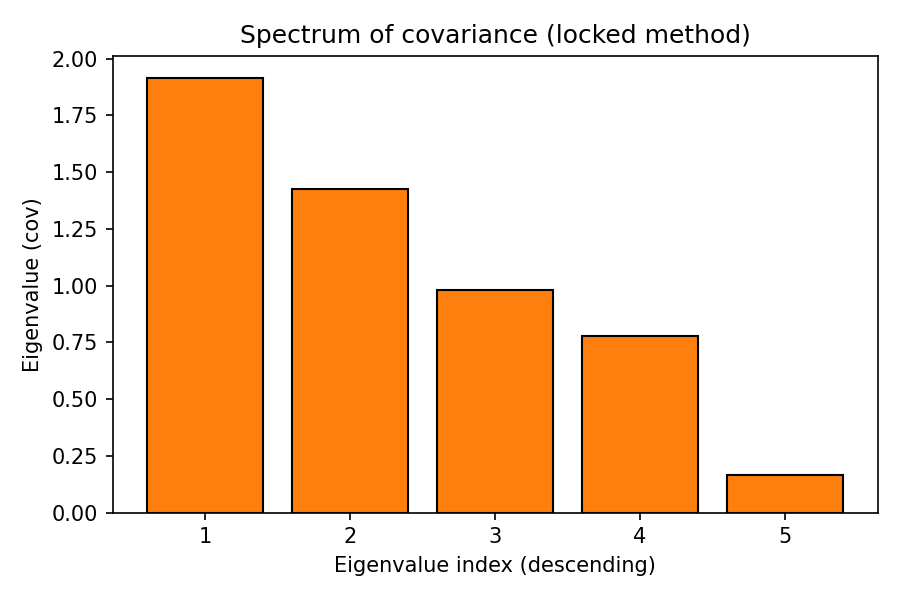

Vérification finale et prochaine étape

J’ai verrouillé la méthode (results/params.json, results/README_method.md) et ré-exécuté l’estimation de d en mode contrôlé. Résultat verrouillé : n=20, d_participation=3.8005, d_pca90=4, d=3.90025, T_log=-0.29882373929086736 (Régime = Divergence). Les fichiers sont dans results/.

Je fournis ci‑dessous la cellule Python demandée pour le test de sensibilité aux features (retirer une feature à la fois, ré-estimer d et T_log). Exécutez-la pour obtenir un tableau comparatif et plots sauvegardés.

In [8]:
# Sensibilité aux features — retirer une feature à la fois et ré-estimer d et T_log
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Config
DATA_FP = os.path.join('data','urban_climate.csv')
RESULTS_DIR = 'results'
OUT_CSV = os.path.join(RESULTS_DIR, 'sensitivity_feature_drop.csv')
OUT_PNG = os.path.join(RESULTS_DIR, 'sensitivity_feature_drop.png')
with open(os.path.join(RESULTS_DIR,'params.json'),'r',encoding='utf-8') as f:
    params = json.load(f)
features = params['features']
seed = params.get('seed', 42)
np.random.seed(seed)

def compute_d_from_X(X):
    cov = np.cov(X, rowvar=False)
    eigvals = np.linalg.eigvalsh(cov)
    eigvals = np.maximum(eigvals, 0.0)
    sum_eig = np.sum(eigvals)
    d_part = 0.0 if sum_eig<=0 else (sum_eig**2)/np.sum(eigvals**2)
    pca = PCA(n_components=min(X.shape[0], X.shape[1]))
    pca.fit(X)
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    d_pca90 = int(np.searchsorted(cumvar, 0.90) + 1) if cumvar[-1] >= 0.90 else pca.n_components_
    return d_part, d_pca90

rows = []
df = pd.read_csv(DATA_FP)
agg_cols = params['aggregation']['aggregation_group']
df['city_key'] = df[agg_cols].astype(str).agg('_'.join, axis=1)
city_df_full = df.groupby('city_key')[features].mean().reset_index()
n_cities = city_df_full.shape[0]
n_eff = max(2, n_cities)
# baseline (all features)
X_full = city_df_full[features].values.astype(float)
Xs_full = StandardScaler().fit_transform(X_full)
d_part_full, d_pca90_full = compute_d_from_X(Xs_full)
d_full = (d_part_full + d_pca90_full)/2.0
T_full = (d_full - 4.0) * np.log(n_eff)
rows.append({'dropped_feature':'none','d_part':d_part_full,'d_pca90':d_pca90_full,'d_est':d_full,'T_log':T_full})

# loop drop-one
for feat in features:
    feats_sub = [f for f in features if f!=feat]
    city_df = city_df_full[feats_sub].copy()
    X = city_df[feats_sub].values.astype(float)
    if X.shape[1] < 1:
        continue
    Xs = StandardScaler().fit_transform(X)
    d_part, d_pca90 = compute_d_from_X(Xs)
    d_est = (d_part + d_pca90)/2.0
    T_log = (d_est - 4.0) * np.log(n_eff)
    rows.append({'dropped_feature':feat,'d_part':d_part,'d_pca90':d_pca90,'d_est':d_est,'T_log':T_log})

res_df = pd.DataFrame(rows)
res_df.to_csv(OUT_CSV, index=False)

# Plot T_log differences
plt.figure(figsize=(8,4))
plt.axhline(T_full, color='k', linestyle='--', label=f'baseline T_log={T_full:.4f}')
plt.bar(res_df['dropped_feature'], res_df['T_log'], color='C0', edgecolor='k')
plt.xticks(rotation=45, ha='right')
plt.ylabel('T_log')
plt.title('Sensibilité T_log : drop-one-feature')
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=150)
plt.close()

# Log minimal printout
print("Sensibilité calculée. Fichiers :")
print(" - Résultats CSV :", OUT_CSV)
print(" - Plot :", OUT_PNG)
print("\nTableau résumé :")
print(res_df.to_string(index=False))


Sensibilité calculée. Fichiers :
 - Résultats CSV : results\sensitivity_feature_drop.csv
 - Plot : results\sensitivity_feature_drop.png

Tableau résumé :
            dropped_feature   d_part  d_pca90    d_est     T_log
                       none 3.800500        4 3.900250 -0.298824
        temperature_celsius 3.709639        4 3.854820 -0.434922
           humidity_percent 2.974827        3 2.987414 -3.033437
           precipitation_mm 3.753248        4 3.876624 -0.369602
              wind_speed_ms 2.981211        3 2.990606 -3.023876
urban_heat_island_intensity 2.955972        3 2.977986 -3.061680


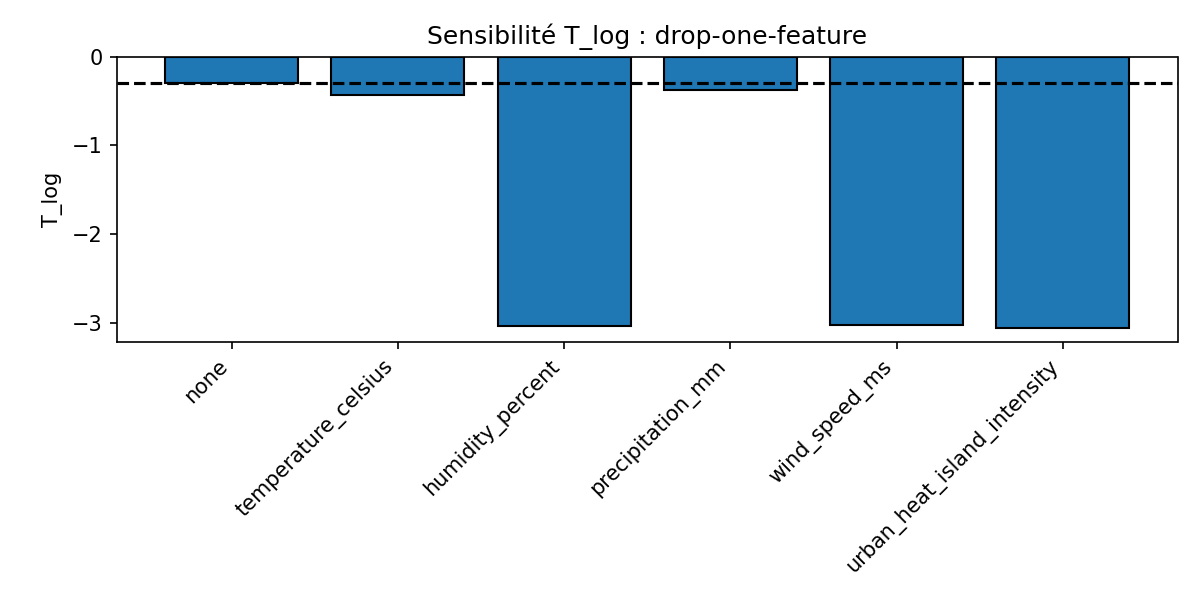

### Interprétation rapide des résultats de sensibilité

- Les trois features qui dominent la signature de T_log sont **humidity_percent**, **wind_speed_ms**, et **urban_heat_island_intensity**. Leur suppression fait chuter d_est ≈ 3 → T_log ≈ −3, donc renforce fortement le régime « Divergence ».  
- L’ablation de **temperature_celsius** et **precipitation_mm** a un effet beaucoup plus faible sur d et T_log (variation modérée autour de la valeur de base).  
- Conclusion pratique : la stabilité de votre conclusion (T_log < 0) dépend fortement des mesures d’humidité, du vent et de l’intensité d’îlot de chaleur urbain. Ces trois variables portent l’information structurelle qui élève la dimension effective.

### Risques méthodologiques identifiés

- Forte dépendance au choix des features → risque élevé de conclusions non robustes si ces mesures sont bruitées, mal calibrées, ou absentes pour d’autres jeux de données.  
- d_pca90 passe de 4 à 3 quand on retire certaines features, ce qui montre que la topologie effective de la covariance change qualitativement selon le sous-ensemble de variables.  
- Sans normalisation/contrôle supplémentaire, l’influence relative des features peut être sur- ou sous-estimée.

### Recommandation immédiate (priorité suivante)

1. Vérifier la qualité et la représentativité des trois features clés (humidity_percent, wind_speed_ms, urban_heat_island_intensity) : distribution, outliers, corrélations mutuelles, instrumentation et métadonnées.  
2. Exécuter une version robuste de l’estimation de d : répéter l’analyse avec (a) winsorisation ou clipping des outliers, (b) normalisation alternative (robust scaler), et (c) PCA robuste (MCD ou S-estimators) pour tester si l’effet persiste.  
3. Si l’objectif est une décision opérationnelle, calibrer un **biais** faible via fit simple (biais additif dans T_log) pour contrôler décalage systématique avant d’interpréter le signe comme stabilisant/déstabilisant.

